In [5]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [8]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 500

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (60000, 28, 28)
Number of labels: 60000


In [10]:
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

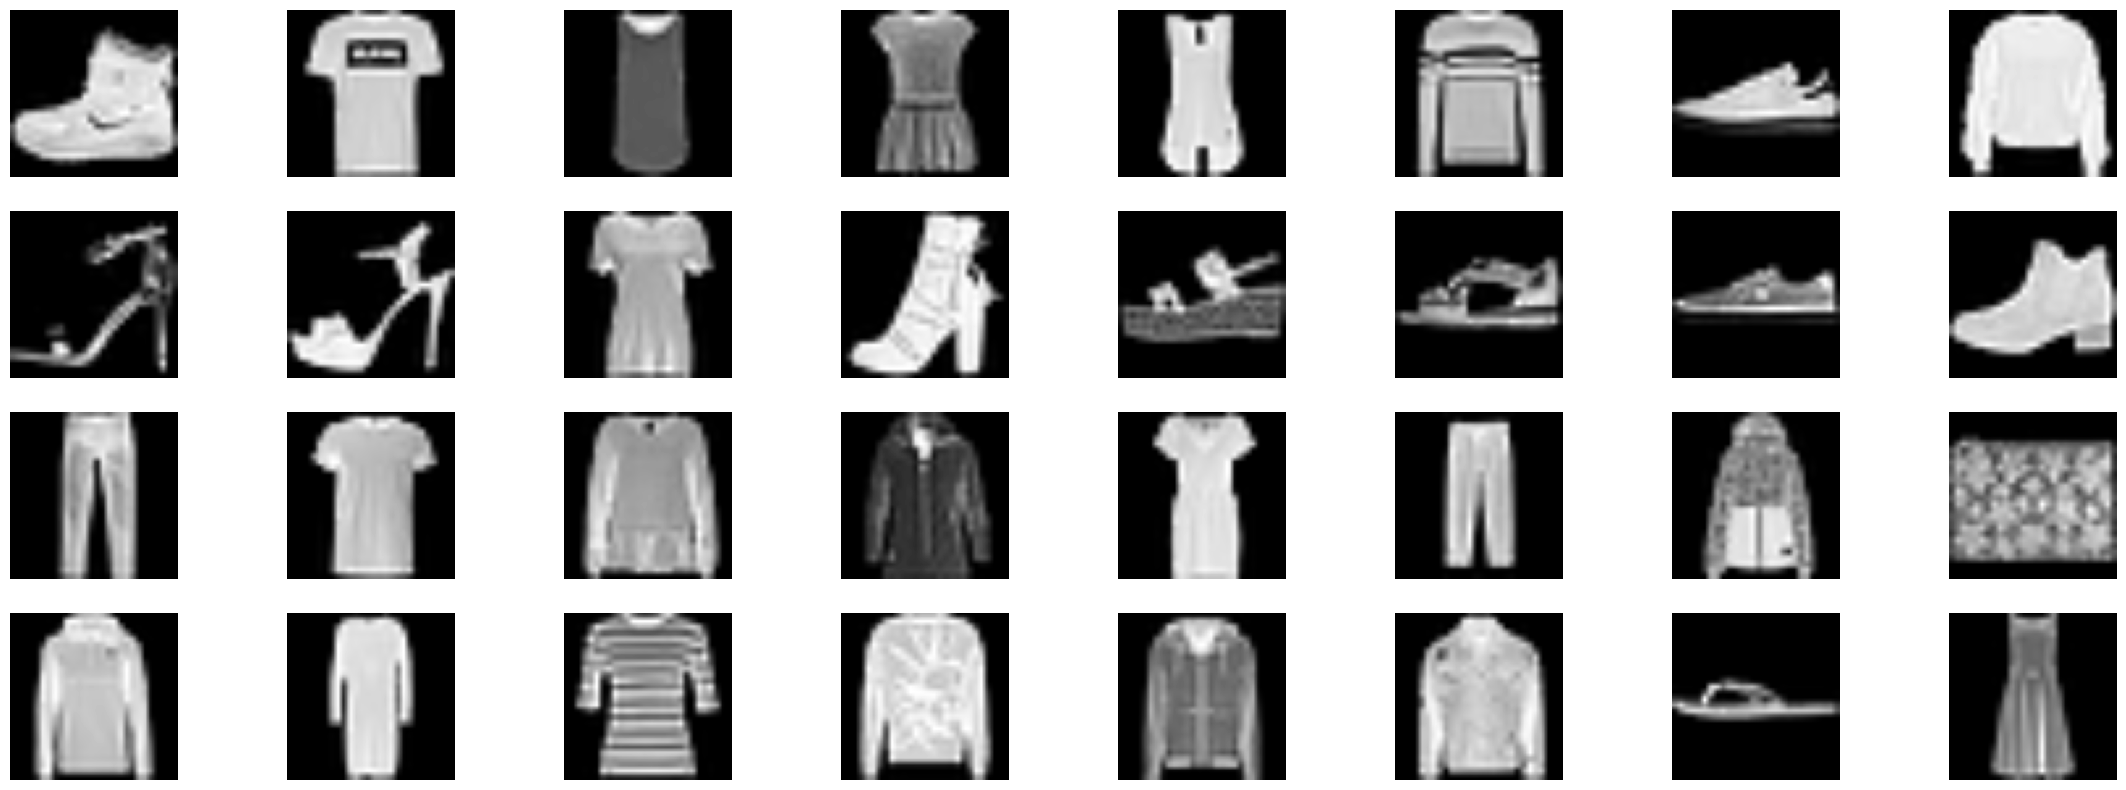

In [11]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    
    counter += 1
    if counter == cnt_imgs:
        break

In [12]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [14]:
hidden_dim = 100

In [16]:
generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))

In [17]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819328    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                         

In [23]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [24]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                401472    
                                                                 
 dense_6 (Dense)             (None, 1)               

In [25]:
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [26]:
@tf.function
def train_step(images) -> (float, float):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss

In [27]:
def train(dataset,  epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in  generator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)

    for epoch in range(1, EPOCHS + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end = ' ')

        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
    return history

In [28]:
EPOCHS = 100
gen_history = train(train_dataset, EPOCHS)

1/100: 

2023-10-25 09:30:37.154636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-10-25 09:30:37.154791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-10-25 09:30:38.057834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-25 09:30:39.16999

==========> : loss = tf.Tensor(7.747051, shape=(), dtype=float32)
The time of the epoch 1 is: 10.470703601837158 second
2/100: ==========> : loss = tf.Tensor(7.255027, shape=(), dtype=float32)
The time of the epoch 2 is: 4.70645809173584 second
3/100: ==========> : loss = tf.Tensor(8.155248, shape=(), dtype=float32)
The time of the epoch 3 is: 4.6858744621276855 second
4/100: ==========> : loss = tf.Tensor(8.493302, shape=(), dtype=float32)
The time of the epoch 4 is: 4.692595720291138 second
5/100: ==========> : loss = tf.Tensor(9.80422, shape=(), dtype=float32)
The time of the epoch 5 is: 4.708346128463745 second
6/100: ==========> : loss = tf.Tensor(10.50922, shape=(), dtype=float32)
The time of the epoch 6 is: 4.702704668045044 second
7/100: ==========> : loss = tf.Tensor(11.035782, shape=(), dtype=float32)
The time of the epoch 7 is: 4.709807395935059 second
8/100: ==========> : loss = tf.Tensor(11.457483, shape=(), dtype=float32)
The time of the epoch 8 is: 4.722078561782837 seco

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


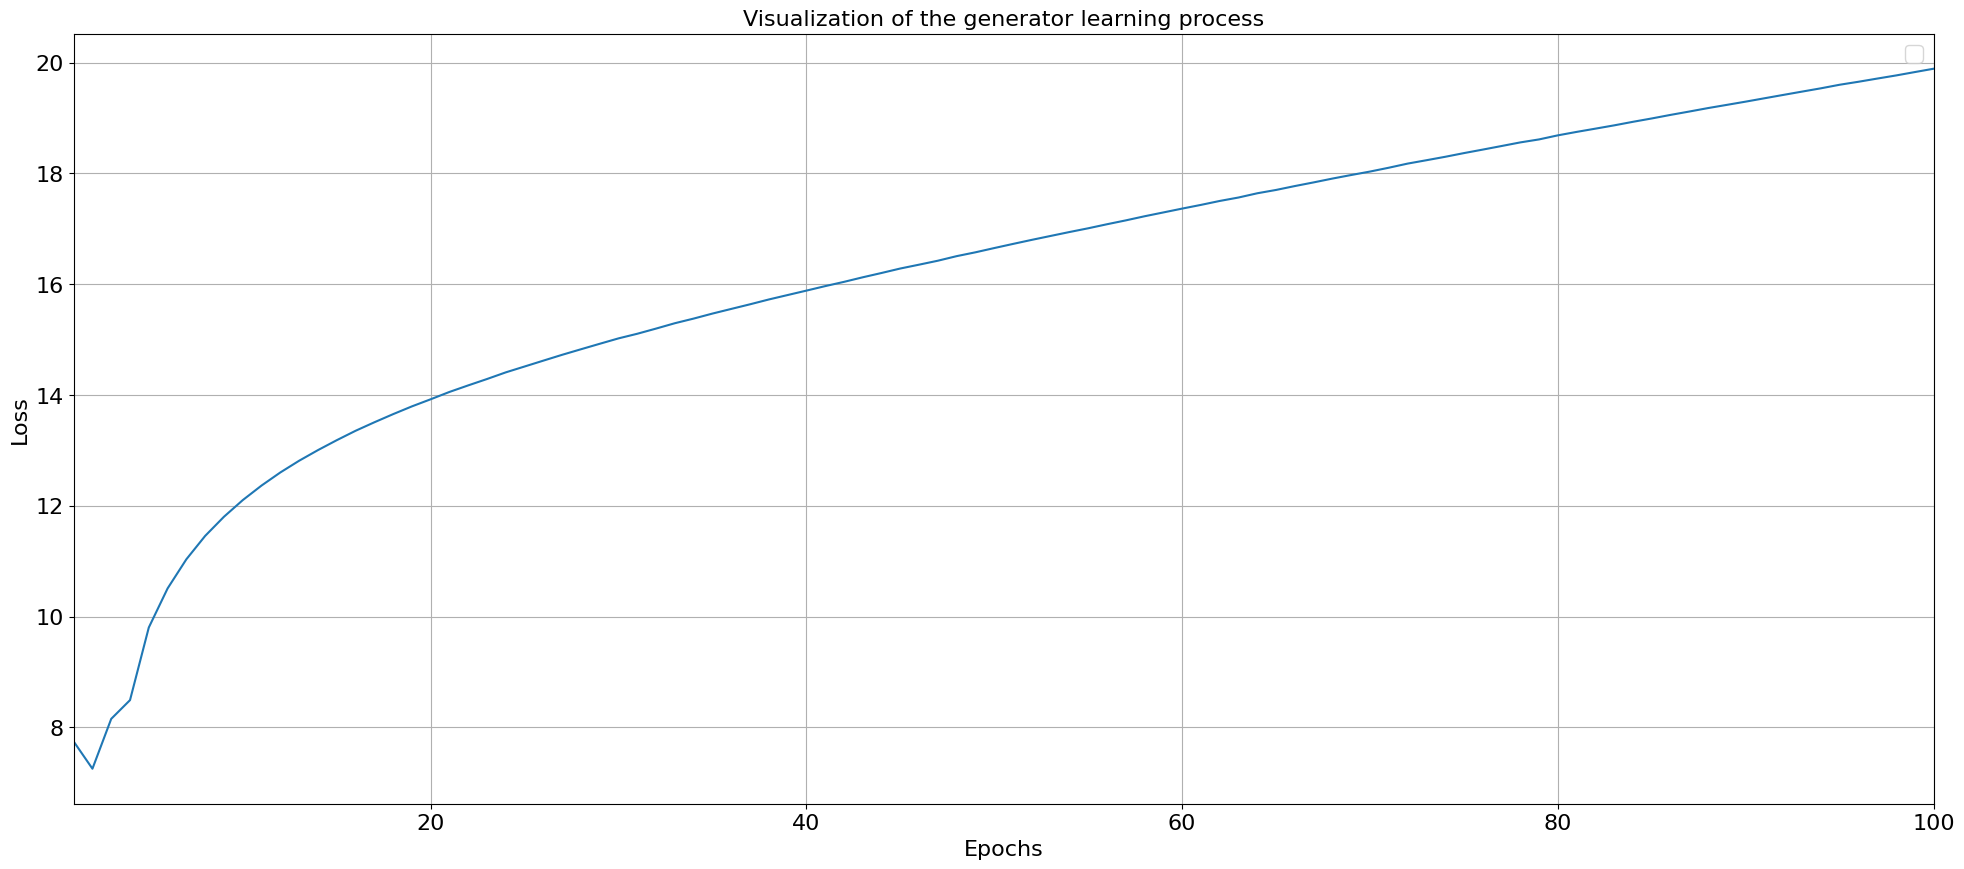

In [29]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

ValueError: in user code:

    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mca/anaconda3/envs/dse/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "generator" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 2)


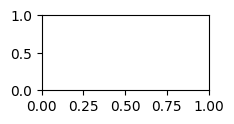

In [30]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()